In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip install mxnet-cu112
import mxnet as mx
mx.context.num_gpus()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


1

In [ ]:
%%capture
!pip install datasetsforecast
!pip install "gluonts[mxnet,pro]"
!pip install git+https://github.com/Nixtla/neuralforecast.git
!pip install git+https://github.com/Nixtla/hierarchicalforecast.git 
!git clone https://github.com/dluuo/HINT.git

In [ ]:
import pydantic
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.mx.trainer import Trainer
from gluonts.dataset.hierarchical import HierarchicalTimeSeries
from gluonts.mx.model.deepvar_hierarchical import DeepVARHierarchicalEstimator

from hierarchicalforecast.evaluation import scaled_crps, msse

#import wrangled datasets
from HINT.src.data.data import HierarchicalDataset

## Auxiliary Functions/Constants

In [ ]:
DATASET = 'TourismLarge'
LEVEL = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in LEVEL]
QUANTILES = np.sort(np.concatenate(qs)/100)

In [ ]:
def get_hierarchical_crps(Y, Y_hat, q_to_pred, tags, model_name='HierE2E'):
    results = {'Level': list(tags.keys()),}
    
    crps_list = []
    for level in results['Level']:
        # Get the series specific to the hierarchical level
        row_idxs = tags[level]
        y     = Y[row_idxs, :]
        y_hat = Y_hat[row_idxs, :, :]

        level_crps  = scaled_crps(y, y_hat, q_to_pred)
        crps_list.append(level_crps)
    
    results[model_name] = crps_list
    return pd.DataFrame(results)

In [ ]:
def get_hierarchical_msse(Y, Y_hat, Y_train, tags, model_name='HierE2E'):
    results = {'Level': list(tags.keys()),}
    
    msse_list = []
    for level in results['Level']:
        # Get the series specific to the hierarchical level
        row_idxs = tags[level]
        y     = Y[row_idxs, :]
        y_hat = Y_hat[row_idxs, :, :]
        y_train = Y_train[row_idxs, :, :]

        level_msse  = msse(y, y_hat, y_train)
        msse_list.append(level_msse)
    
    results[model_name] = msse_list
    return pd.DataFrame(results)

## Hierarchical Dataset

In [ ]:
# read file
with open('HINT/src/baselines/best_hps_HierE2E.jsonl', 'r') as myfile:
    data=myfile.read()

# parse file
config = json.loads(data)
hdataset = HierarchicalDataset()

data = hdataset.load_process_data(dataset=DATASET)

if DATASET == 'Labour':
    bottom_cols = data['tags']['Country/Employment/Gender/Region']
    config = config['labour']
elif DATASET == 'Traffic':
    bottom_cols = data['tags']['Level4']
    config = config['traffic']
elif DATASET == 'TourismLarge':
    bottom_cols = data['tags']['Country/State/Zone/Region/Purpose']
    config = config['tourismlarge']
elif DATASET == 'TourismSmall':
    bottom_cols = data['tags']['Country/Purpose/State/CityNonCity']
    config = config['tourismsmall']
elif DATASET == 'Wiki2':
    bottom_cols = data['tags']['Views/Country/Access/Agent/Topic']
    config = config['wiki2']

Y_bottom_df = data['Y_df'].pivot(index='ds', columns='unique_id', values='y')
Y_bottom_df = Y_bottom_df.loc[:, bottom_cols].to_period()

#get tags and turn into dictionary
tags = data['hier_idxs']
tags = {k: v for k, v in enumerate(tags)}
#get prediction length
prediction_length = data['seasonality']

S = data['S_df'].values

hts_train = HierarchicalTimeSeries(
    ts_at_bottom_level=Y_bottom_df.iloc[:-prediction_length, :],
    S=S)
hts_test = HierarchicalTimeSeries(
    ts_at_bottom_level=Y_bottom_df.iloc[-prediction_length:, :],
    S=S,
)

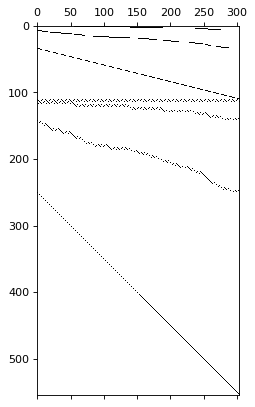

In [ ]:
plt.figure(num=1, figsize=(4, 6), dpi=80, facecolor='w')
plt.spy(S)
plt.show()
plt.close()

In [ ]:
hts_train.ts_at_all_levels.tail()

,0,1,2,3,4,5,6,7,8,9,...,545,546,547,548,549,550,551,552,553,554
ds,,,,,,,,,,,,,,,,,,,,,
2015-08,24002.546778,7128.244522,4147.014370,6666.976942,1299.440434,3471.119861,433.925581,855.825067,1977.862310,1841.123842,...,18.352151,0.0,64.281907,36.321549,6.949832,4.420944,14.816798,2.971898,3.549181,17.683774
2015-09,24902.660910,7142.632359,4342.727842,7646.475258,1278.933403,3536.384785,496.369798,459.137465,2401.969501,1839.418888,...,0.000000,0.0,122.529091,0.000000,25.908366,0.237036,7.192230,0.000000,0.289355,0.000000
2015-10,27184.062020,8088.210826,5142.343235,6636.808118,2130.846154,3495.863847,846.956053,843.033786,2335.378492,2058.114076,...,17.225169,0.0,46.338851,16.015553,27.892484,0.000000,1.953048,10.506795,0.000000,0.000000
2015-11,26563.142602,8871.980669,5038.076915,5937.752456,1513.434501,3702.734933,1008.986557,490.176570,2481.750006,2614.287386,...,1.297009,0.0,5.946392,0.449960,13.508290,0.000000,0.179138,0.000000,8.788995,0.000000
2015-12,24982.024450,7166.123756,5340.151278,5621.323498,1871.762793,3662.918391,903.123744,416.620991,2107.393803,2084.694399,...,0.000000,0.0,2.438621,83.718322,23.297512,0.000000,19.694950,0.187404,11.604291,0.000000


In [ ]:
hts_test.ts_at_all_levels.tail()

,0,1,2,3,4,5,6,7,8,9,...,545,546,547,548,549,550,551,552,553,554
ds,,,,,,,,,,,,,,,,,,,,,
2016-08,24100.446632,7227.612582,4000.422405,7536.939346,1230.321700,2868.505157,355.515713,881.129730,2305.649511,1872.238140,...,7.874448,0.000000,49.899947,8.300225,17.633478,8.218562,4.121631,0.408894,1.625820,0.0
2016-09,24800.033759,6778.363226,4132.168965,7123.112802,1632.732153,3327.064770,525.302974,1281.288869,2061.246613,1834.682010,...,0.421996,0.000000,80.058887,37.306013,109.024164,46.447153,11.661140,3.557735,4.448534,0.0
2016-10,30039.106985,8592.998250,5719.297913,8759.191781,1900.476487,3704.651986,895.180382,467.310186,2267.174784,2654.233485,...,35.375093,0.273247,52.156131,2.093902,50.283538,3.319366,0.754941,0.000000,0.000000,0.0
2016-11,27320.918908,8663.240960,5165.403172,6804.359328,1543.299435,3698.431886,852.313563,593.870565,2786.280116,2537.103416,...,10.723090,39.292496,8.344998,7.697995,43.270319,0.000000,0.000000,0.000000,5.180648,0.0
2016-12,24604.310774,7953.659899,5000.483536,6049.188583,1378.418047,2844.820274,876.351928,501.388506,2676.459548,2079.657819,...,0.000000,0.000000,2.418446,0.000000,0.762140,1.055685,0.000000,0.000000,9.966514,0.0


## Train HierE2E

In [25]:
dataset_train = hts_train.to_dataset()

estimator = DeepVARHierarchicalEstimator(
    # freq=hts_train.freq,
    freq="M", #only for TourismSmall since DeepVARHierarchicalEstimator cannot do 'Q' Freq
    prediction_length=prediction_length,
    target_dim=hts_train.num_ts,
    S=S,
    trainer=Trainer(ctx = mx.context.gpu(),
                    epochs=config['epochs'],
                    num_batches_per_epoch=config['num_batches_per_epoch'],
                    hybridize=config['hybridize'],
                    learning_rate=config['learning_rate']),
    scaling=config['scaling'],
    pick_incomplete=config['pick_incomplete'],
    batch_size=config['batch_size'],
    num_parallel_samples=config['num_parallel_samples'],
    context_length=config['context_length'],
    num_layers=config['num_layers'],
    num_cells=config['num_cells'],
    coherent_train_samples=config['coherent_train_samples'],
    coherent_pred_samples=config['coherent_pred_samples'],
    likelihood_weight=config['likelihood_weight'],
    CRPS_weight=config['CRPS_weight'],
    num_samples_for_loss=config['num_samples_for_loss'],
    sample_LH=config['sample_LH'],
    seq_axis=config['seq_axis'],
    warmstart_epoch_frac = config['warmstart_epoch_frac'],
)

predictor = estimator.train(dataset_train)
forecast_it = predictor.predict(dataset_train)

Y_hat = next(forecast_it).samples
Y_hat = np.quantile(Y_hat, q=QUANTILES, axis=0)
Y_hat = np.transpose(Y_hat, (2,1,0))

Y_test = hts_test.ts_at_all_levels.values # [Q, T, n_series] -> [n_series,T,Q]
Y_test = np.transpose(Y_test, (1,0)) 

Y_train = hts_train.ts_at_all_levels.values # [Q, T, n_series] -> [n_series,T,Q]
Y_train = np.transpose(Y_train, (1,0))

print('Y_hat.shape', Y_hat.shape)
print('Y_test.shape', Y_test.shape)
print('Y_train.shape', Y_train.shape)

100%|██████████| 50/50 [00:16<00:00,  3.06it/s, epoch=40/40, avg_epoch_loss=2.75e+3]


Y_hat.shape (555, 12, 100)
Y_test.shape (555, 12)
Y_train.shape (555, 216)


In [26]:
get_hierarchical_crps(Y=Y_test, Y_hat=Y_hat, tags=tags, q_to_pred=QUANTILES)

,Level,HierE2E
0,0,0.147084
1,1,0.082149
2,2,0.096971
3,3,0.130210
4,4,0.168864
5,5,0.103883
6,6,0.135996
7,7,0.196220
8,8,0.262382
